In [1]:
import os
import math
import time
import numpy as np
import pickle

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from deepst.models.STResNet import stresnet
from deepst.datasets import BikeNYC
from deepst.config import Config
from deepst import metrics

In [5]:
class STResNetHandler:

    def __init__(self, nb_epoch = 500, batch_size = 32, lr = 0.0002, nb_residual_unit = 4):
        self.nb_epoch = nb_epoch # Number of epochs at the training stage
        self.batch_size = batch_size  # Batch size
        self.nb_residual_unit = nb_residual_unit   # Number of residual units in Model
        self.lr = lr  # Learning rate

        self.T = 24 # Number of time intervals in one day
        self.len_closeness = 3  # Length of closeness-dependent sequence
        self.len_period = 4 # Length of period-dependent sequence
        self.len_trend = 4 # Length of trend-dependent sequence

        #Change following attributes if not using BikeNYC dataset
        self.nb_flow = 2  # Number of flow types: new-flow and end-flow
        self.days_test = 10 # Number of days in the test set
        self.map_height = 16 # Grid height
        self.map_width = 8 # Grid Width
        self.nb_area = 81 # Number of grid-based areas for NYC Bike data

        self.len_test = self.T * self.days_test # Length of the test set
        self.m_factor = math.sqrt(1. * self.map_height * self.map_width / self.nb_area) # Factor for modifying the final RMSE
        print('factor: ', self.m_factor)

        self.path_result = 'RET' # Directory for result files
        self.path_model = 'MODEL' # Directory for model checkpoints
        self.manage_directories()

        np.random.seed(1337) # for reproducibility


    def manage_directories(self):
        # Creating result and model directories if they don't exist
        if not os.path.isdir(self.path_result):
            os.mkdir(self.path_result)
        if not os.path.isdir(self.path_model):
            os.mkdir(self.path_model)


    def build_model(self, external_dim):
        c_conf = (self.len_closeness, self.nb_flow, self.map_width, self.map_height) if self.len_closeness > 0 else None
        p_conf = (self.len_period, self.nb_flow, self.map_width, self.map_height) if self.len_period > 0 else None
        t_conf = (self.len_trend, self.nb_flow, self.map_width, self.map_height) if self.len_trend > 0 else None

        model = stresnet(c_conf=c_conf, p_conf=p_conf, t_conf=t_conf, external_dim=external_dim, nb_residual_unit=self.nb_residual_unit)

        adam = Adam(lr=self.lr)
        model.compile(loss='mse', optimizer=adam, metrics=[metrics.rmse])
        model.summary()

        return model


    def load_data(self):
        X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = BikeNYC.load_data(
            T=self.T, nb_flow=self.nb_flow, len_closeness=self.len_closeness, len_period=self.len_period,
            len_trend=self.len_trend, len_test=self.len_test, preprocess_name='preprocessing.pkl', meta_data=True
        )
        return X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test


    def train_model(self, model, X_train, Y_train, X_test, Y_test, hyperparams_name, early_stopping, model_checkpoint):
        print('=' * 10)
        print("training model...")

        # Train the model
        history = model.fit(X_train, Y_train,
                            epochs=self.nb_epoch,
                            batch_size=self.batch_size,
                            validation_split=0.1,
                            callbacks=[early_stopping, model_checkpoint],
                            verbose=1)

        return history


    def save_model_and_history(self, model, hyperparams_name, history):
        # Saving model weights and training history
        model.save_weights(os.path.join('MODEL', '{}.h5'.format(hyperparams_name)), overwrite=True)
        pickle.dump((history.history), open(os.path.join(self.path_result, '{}.history.pkl'.format(hyperparams_name)), 'wb'))


    def evaluate_model(self, model, X_train, Y_train, X_test, Y_test, mmn, fname_param):
        print('=' * 10)
        print('evaluating using the model that has the best loss on the valid set')

        # Loading the best model and evaluating on the training set
        model.load_weights(fname_param)
        score = model.evaluate(X_train, Y_train, batch_size=Y_train.shape[0] // 48, verbose=0)
        print('Train score: %.6f rmse (norm): %.6f rmse (real): %.6f' % (score[0], score[1], score[1] * (mmn._max - mmn._min) / 2. * self.m_factor))

        # Evaluating the model on the test set
        score = model.evaluate(X_test, Y_test, batch_size=Y_test.shape[0], verbose=0)
        print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' % (score[0], score[1], score[1] * (mmn._max - mmn._min) / 2. * self.m_factor))


    def main(self):
        print("loading data...")
        
        X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = self.load_data()

        print("\n days (test): ", [v[:8] for v in timestamp_test[0::self.T]])

        print('=' * 10)
        print("compiling model...")

        # Build the STResNet Model
        model = self.build_model(external_dim)
        hyperparams_name = 'c{}.p{}.t{}.resunit{}.lr{}'.format(self.len_closeness, self.len_period, self.len_trend, self.nb_residual_unit, self.lr)

        fname_param = os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name))

        # Setting up callbacks for early stopping and model checkpoint
        early_stopping = EarlyStopping(monitor='val_rmse', patience=5, mode='min')
        model_checkpoint = ModelCheckpoint(fname_param, monitor='val_rmse', verbose=0, save_best_only=True, mode='min')

        print('=' * 10)
        print("training model...")

        # Train the model
        history = self.train_model(model, X_train, Y_train, X_test, Y_test, hyperparams_name, early_stopping, model_checkpoint)

        # Saving model weights and training history
        self.save_model_and_history(model, hyperparams_name, history)

        print('=' * 10)
        print('evaluating using the model that has the best loss on the valid set')

        # Loading the best model and evaluating on the training set
        self.evaluate_model(model, X_train, Y_train, X_test, Y_test, mmn, fname_param)


if __name__ == "__main__":
    trainer = STResNetHandler()
    trainer.main()

factor:  1.2570787221094177
loading data...
('incomplete days: ', [])
train_data shape:  (4152, 2, 16, 8)
min: 0.0 max: 267.0
XC shape:  (3720, 6, 16, 8) XP shape:  (3720, 8, 16, 8) XT shape:  (3720, 8, 16, 8) Y shape: (3720, 2, 16, 8)
XC shape:  (3720, 8, 16, 6) XP shape:  (3720, 8, 16, 8) XT shape:  (3720, 8, 16, 8) Y shape: (3720, 8, 16, 2)
train shape: (3480, 8, 16, 6) (3480, 8, 16, 2) test shape:  (240, 8, 16, 6) (240, 8, 16, 2)
(3480, 8, 16, 6)
(3480, 8, 16, 8)
(3480, 8, 16, 8)
(3480, 8)

(240, 8, 16, 6)
(240, 8, 16, 8)
(240, 8, 16, 8)
(240, 8)


 days (test):  [b'20140921', b'20140922', b'20140923', b'20140924', b'20140925', b'20140926', b'20140927', b'20140928', b'20140929', b'20140930']
compiling model...
**at the first time, it takes a few minutes to compile if you use [Theano] as the backend**


c:\Users\awa18001\AppData\Local\anaconda3\envs\main\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 8, 16, 6)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 8, 16, 8)]   0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 8, 16, 8)]   0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 8, 16, 64)    3520        input_5[0][0]                    
____________________________________________________________________________________________

KeyboardInterrupt: 

In [18]:
class STResNetHandler:

    def __init__(self, nb_epoch=500, batch_size=64, lr=0.0002, nb_residual_unit=4):
        self.nb_epoch = nb_epoch  # Number of epochs at the training stage
        self.batch_size = batch_size  # Batch size
        self.nb_residual_unit = nb_residual_unit  # Number of residual units in Model
        self.lr = lr  # Learning rate

        self.T = 24  # Number of time intervals in one day
        self.len_closeness = 3  # Length of closeness-dependent sequence
        self.len_period = 4  # Length of period-dependent sequence
        self.len_trend = 4  # Length of trend-dependent sequence
        self.nb_flow = 2  # Number of flow types: new-flow and end-flow
        self.days_test = 10  # Number of days in the test set
        self.map_height = 16  # Grid height
        self.map_width = 8  # Grid Width
        self.nb_area = 81  # Number of grid-based areas for NYC Bike data

        self.len_test = self.T * self.days_test  # Length of the test set
        self.m_factor = math.sqrt(1. * self.map_height * self.map_width / self.nb_area)  # Factor for modifying the final RMSE
        print('factor: ', self.m_factor)

        self.path_result = 'RET'  # Directory for result files
        self.path_model = 'MODEL'  # Directory for model checkpoints
        self.manage_directories()

        np.random.seed(1337)  # for reproducibility


    def manage_directories(self):
        # Creating result and model directories if they don't exist
        if not os.path.isdir(self.path_result):
            os.mkdir(self.path_result)
        if not os.path.isdir(self.path_model):
            os.mkdir(self.path_model)


    def build_model(self, external_dim):
        c_conf = (self.len_closeness, self.nb_flow, self.map_width, self.map_height) if self.len_closeness > 0 else None
        p_conf = (self.len_period, self.nb_flow, self.map_width, self.map_height) if self.len_period > 0 else None
        t_conf = (self.len_trend, self.nb_flow, self.map_width, self.map_height) if self.len_trend > 0 else None

        model = stresnet(c_conf=c_conf, p_conf=p_conf, t_conf=t_conf, external_dim=external_dim, nb_residual_unit=self.nb_residual_unit)

        adam = Adam(lr=self.lr)
        model.compile(loss='mse', optimizer=adam, metrics=[metrics.rmse])
        model.summary()

        return model


    def load_data(self):
        X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = BikeNYC.load_data(
            T=self.T, nb_flow=self.nb_flow, len_closeness=self.len_closeness, len_period=self.len_period,
            len_trend=self.len_trend, len_test=self.len_test, preprocess_name='preprocessing.pkl', meta_data=True
        )
        
        return X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test


    def train_model(self, model, X_train, Y_train, early_stopping, model_checkpoint):
        # Train the model
        history = model.fit(X_train, Y_train,
                            epochs=self.nb_epoch,
                            batch_size=self.batch_size,
                            validation_split=0.1,
                            callbacks=[early_stopping, model_checkpoint],
                            verbose=1)

        return history


    def save_model_and_history(self, model, hyperparams_name, history):
        # Saving model weights and training history
        model.save_weights(os.path.join('MODEL', '{}.h5'.format(hyperparams_name)), overwrite=True)
        pickle.dump((history.history), open(os.path.join(self.path_result, '{}.history.pkl'.format(hyperparams_name)), 'wb'))


    def evaluate_model(self, model, X_train, Y_train, X_test, Y_test, mmn, fname_param):
        # Loading the best model and evaluating on the training set
        model.load_weights(fname_param)

        score = model.evaluate(X_train, Y_train, batch_size=Y_train.shape[0] // 48, verbose=0)
        print('Train score: %.6f rmse (norm): %.6f rmse (real): %.6f' % (
            score[0], score[1], score[1] * (mmn._max - mmn._min) / 2. * self.m_factor))

        # Evaluating the model on the test set
        score = model.evaluate(X_test, Y_test, batch_size=Y_test.shape[0], verbose=0)
        print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' % (
            score[0], score[1], score[1] * (mmn._max - mmn._min) / 2. * self.m_factor))


    def main(self):
        print("loading data...")

        X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = self.load_data()

        print("\n days (test): ", [v[:8] for v in timestamp_test[0::self.T]])

        print('=' * 10)
        print("compiling model...")

        # Build the STResNet Model
        model = self.build_model(external_dim)
        hyperparams_name = 'c{}.p{}.t{}.resunit{}.lr{}'.format(self.len_closeness, self.len_period, self.len_trend, self.nb_residual_unit, self.lr)

        fname_param = os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name))

        # Setting up callbacks for early stopping and model checkpoint
        early_stopping = EarlyStopping(monitor='val_rmse', patience=5, mode='min')
        model_checkpoint = ModelCheckpoint(fname_param, monitor='val_rmse', verbose=0, save_best_only=True, mode='min')

        print('=' * 10)
        print("training model...")

        # Train the model
        history = self.train_model(model, X_train, Y_train, early_stopping, model_checkpoint)

        # Saving model weights and training history
        self.save_model_and_history(model, hyperparams_name, history)

        print('=' * 10)
        print('evaluating using the model that has the best loss on the valid set')

        # Loading the best model and evaluating on the test set
        self.evaluate_model(model, X_train, Y_train, X_test, Y_test, mmn, fname_param)


if __name__ == "__main__":
    trainer = STResNetHandler()
    trainer.main()

factor:  1.2570787221094177
loading data...
('incomplete days: ', [])
train_data shape:  (4152, 2, 16, 8)
min: 0.0 max: 267.0
XC shape:  (3720, 6, 16, 8) XP shape:  (3720, 8, 16, 8) XT shape:  (3720, 8, 16, 8) Y shape: (3720, 2, 16, 8)
XC shape:  (3720, 8, 16, 6) XP shape:  (3720, 8, 16, 8) XT shape:  (3720, 8, 16, 8) Y shape: (3720, 8, 16, 2)
train shape: (3480, 8, 16, 6) (3480, 8, 16, 2) test shape:  (240, 8, 16, 6) (240, 8, 16, 2)
(3480, 8, 16, 6)
(3480, 8, 16, 8)
(3480, 8, 16, 8)
(3480, 8)

(240, 8, 16, 6)
(240, 8, 16, 8)
(240, 8, 16, 8)
(240, 8)


 days (test):  [b'20140921', b'20140922', b'20140923', b'20140924', b'20140925', b'20140926', b'20140927', b'20140928', b'20140929', b'20140930']
compiling model...
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 8, 16, 6)]   0      

In [36]:
batch_size = np.array([32, 48, 64])
cpu_secs_per_epoch = np.array([30.28, 26.32, 23])
gpu_secs_per_epoch = np.array([2.2, 1.22, 1.2])
test_rmse_score = np.array([6.565268, 6.715089, 7.183160])
epochs_used = np.array([54, 57, 56])
cpu_total_execution_time = np.array([x * y for x, y in zip(epochs_used, cpu_secs_per_epoch)])
gpu_total_execution_time = np.array([x * y for x, y in zip(epochs_used, gpu_secs_per_epoch)])

#results on 500 epochs (w/ early stopping on (stops when 5 consecutive epochs have not resulted in improvement))

#CPU 32 batch size
# evaluating using the model that has the best loss on the valid set
# Train score: 0.001269 rmse (norm): 0.035565 rmse (real): 5.968523
# Test score: 0.001490 rmse (norm): 0.038597 rmse (real): 6.477357

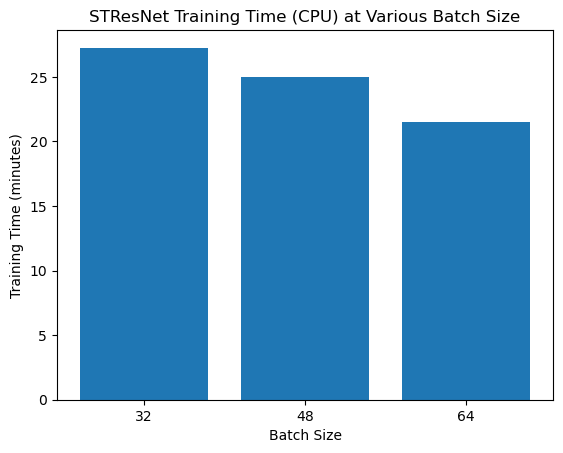

In [43]:
import matplotlib.pyplot as plt

labels = ['32', '48', '64']

# Plotting the bar graph
plt.bar(labels, cpu_total_execution_time / 60)

# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('Training Time (minutes)')
plt.title('STResNet Training Time (CPU) at Various Batch Size')

# Display the plot
plt.show()

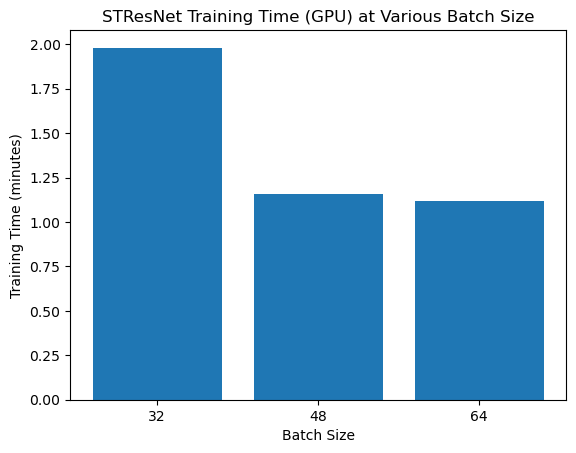

In [42]:
# Plotting the bar graph
plt.bar(labels, gpu_total_execution_time / 60)

# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('Training Time (minutes)')
plt.title('STResNet Training Time (GPU) at Various Batch Size')

# Display the plot
plt.show()

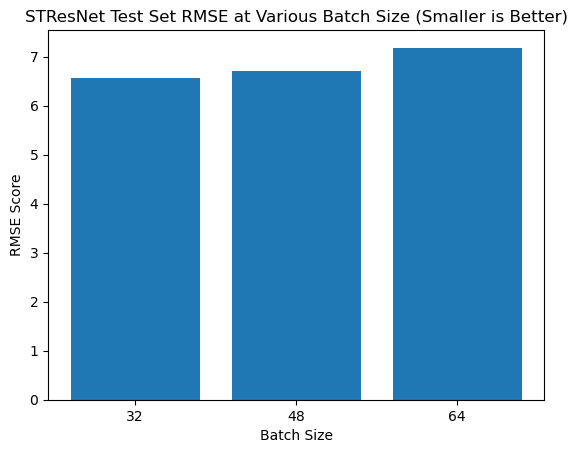

In [45]:
# Plotting the bar graph
plt.bar(labels, test_rmse_score)

# Adding labels and title
plt.xlabel('Batch Size')
plt.ylabel('RMSE Score')
plt.title('STResNet Test Set RMSE at Various Batch Size (Smaller is Better)')

# Display the plot
plt.show()

In [ ]:
#Using GPU is around 15x faster
#Testing done on 500 epochs with early stopping (w/ early stopiing, on average training stops at around 60 epochs)
#different batch sizes do not have considerable effect on model performance